In [1]:
# load data
import pickle

with open("data/conceptnet/embedding.pkl", "rb") as f:
    embedding = pickle.load(f)
    
with open("data/conceptnet/embedding_values.pkl", "rb") as f:
    embedding_values = pickle.load(f)
    
with open("data/conceptnet/embedding_keys.pkl", "rb") as f:
    embedding_keys = pickle.load(f)

In [2]:
with open("data/conceptnet/train100k.txt", "r") as f:
    data_file = f.readlines()
data = []
for item in data_file:
    line = item.strip().split("\t")
    data.append(line)

train_data = []
for i, item in enumerate(data):
    item1 = item[1].replace(" ", "_")
    item2 = item[2].replace(" ", "_")
    if (item1 in embedding_keys) and (item2 in embedding_keys):
        train_data.append([item[0], item1, item2])


In [267]:
relation = []
for item in data:
    relation.append(item[0])
relation = list(set(relation))

import torch
import dgl

# proprocessing the graph data
# create a DGL graph
N_NODES = len(embedding_keys)
N_EDGES = len(train_data)
N_RELATIONS = len(relation)

g = dgl.DGLGraph()
g.add_nodes(N_NODES)
for i in range(N_EDGES):
    item = train_data[i]
    src = embedding_keys.index(item[1])
    dst = embedding_keys.index(item[2])
    g.add_edges(src, dst)
    #print(item, g.edges[src, dst].data)
    if g.edges[src, dst].data == {}:
        g.edges[src, dst].data['rel_type'] = torch.Tensor([relation.index(item[0])]).long()
    else:
        if int(g.edges[src, dst].data["rel_type"].shape[0]) > 1:
            g.edges[src, dst].data['rel_type'][-1] = torch.Tensor([relation.index(item[0])]).long()
        else:
            g.edges[src, dst].data['rel_type'] = torch.Tensor([relation.index(item[0])]).long()
    #print(g.edges[src, dst].data['w'][num - 1, relation.index(item[0])])

# sanity check
g

DGLGraph(num_nodes=4578, num_edges=18653,
         ndata_schemes={}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.int64)})

In [4]:
# subsample a strongly-connected subgraph
import networkx as nx
G_nx = g.to_networkx()
sub_G_nx = nx.strongly_connected_components(G_nx)
SCC = []
for item in sub_G_nx:
    if len(item) > 2:
        SCC.append(item)
component = list(SCC[0])
print(len(component))

2408


In [5]:
# assign embedding to graph
g.ndata["x"] = embedding_values
sub_graph = g.subgraph(component)
sub_graph.copy_from_parent()
sub_graph_G = sub_graph
sub_graph_G

DGLGraph(num_nodes=2408, num_edges=13603,
         ndata_schemes={'x': Scheme(shape=(300,), dtype=torch.float64)}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.int64)})

In [11]:
g.out_edges(0)

(tensor([0]), tensor([4511]))

In [226]:
import numpy as np
def generate_neighbor(subgraph_nodes, graph_G):
    potential_nodes = torch.Tensor([]).long()
    for i, node in enumerate(subgraph_nodes):
        out_edges = graph_G.out_edges(node)[1].numpy()
        in_edges = graph_G.in_edges(node)[0].numpy()
        if len(out_edges) > 3:
            out_edges = np.random.choice(out_edges, 3, replace = False)
        if len(in_edges) > 3:
            in_edges = np.random.choice(in_edges, 3, replace = False)
        potential_nodes = torch.cat([potential_nodes, torch.from_numpy(out_edges)])
        potential_nodes = torch.cat([potential_nodes, torch.from_numpy(in_edges)])
    return set(list(potential_nodes.numpy()))

In [257]:
# create graph subsampler
import copy
def create_graph_sampler(init_node = 1, expand_scale = 3, layer = 5):
    sub_graph_G.readonly()
    neighbor_sampler = dgl.contrib.sampling.sampler.NeighborSampler(sub_graph_G, init_node, expand_scale, layer)

    sampler_list = []
    for item in neighbor_sampler:
        sampler_list.append(item)
    return sampler_list

def gen_subgraph_nodes(sampler_list, index = 0, num = 15):
    nodeflow = sampler_list[index]
    node_list = []
    for i in range(nodeflow.num_layers - 1, -1, -1):
        #print(list(nodeflow.layer_parent_nid(i).numpy()))
        node_list = node_list + list(nodeflow.layer_parent_nid(i).numpy())
    selected_node_list = set(node_list[:num])
    if len(selected_node_list) == num:
        return list(selected_node_list)
    else:
        start = num
        end = 2*num - len(selected_node_list)
        while True:
            selected_node_list = list(selected_node_list)
            selected_node_list = set(selected_node_list + node_list[start:end])
            start = copy.deepcopy(end)
            end = end + num - len(selected_node_list)
            if len(selected_node_list) == num:
                return list(selected_node_list)
#graph_S = sub_graph_G.subgraph(node_list)
#graph_S.copy_from_parent()
node_list = gen_subgraph_nodes(create_graph_sampler())
potential_node = generate_neighbor(node_list, sub_graph_G)

In [258]:
# choose k potential nodes
#potential_node = np.random.choice(np.array(list(potential_node)), 3)
potential_node = potential_node - set(node_list)
print(len(potential_node), len(node_list))
print(potential_node, node_list)

64 15
{771, 2308, 2315, 525, 2065, 2068, 2069, 2073, 2077, 1823, 1057, 1315, 1062, 1833, 41, 1835, 53, 2107, 1596, 322, 2371, 2382, 1102, 1106, 850, 1876, 1875, 342, 1118, 1375, 1636, 101, 103, 105, 364, 119, 2168, 1918, 1919, 897, 2178, 130, 1670, 655, 929, 1697, 1199, 1201, 2229, 1986, 1224, 1225, 461, 2013, 992, 740, 2277, 2279, 488, 2025, 1514, 1779, 249, 251} [0, 1506, 294, 1545, 9, 203, 2190, 79, 304, 1686, 151, 1976, 1850, 2301, 1278]


In [259]:
potential_node = list(potential_node)

graph_S = sub_graph_G.subgraph(node_list)
graph_S.copy_from_parent()

graph_G = sub_graph_G.subgraph(node_list + potential_node[:10])
graph_G.copy_from_parent()

print(graph_G, '\n', graph_S)

DGLGraph(num_nodes=25, num_edges=43,
         ndata_schemes={'x': Scheme(shape=(300,), dtype=torch.float64)}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.int64)}) 
 DGLGraph(num_nodes=15, num_edges=24,
         ndata_schemes={'x': Scheme(shape=(300,), dtype=torch.float64)}
         edata_schemes={'rel_type': Scheme(shape=(), dtype=torch.int64)})


15 64


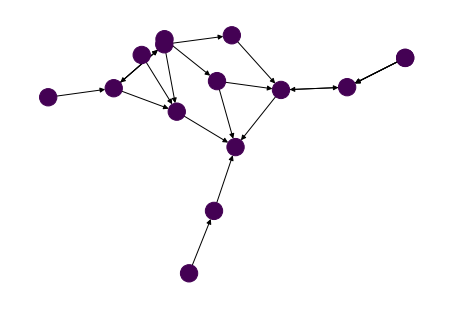

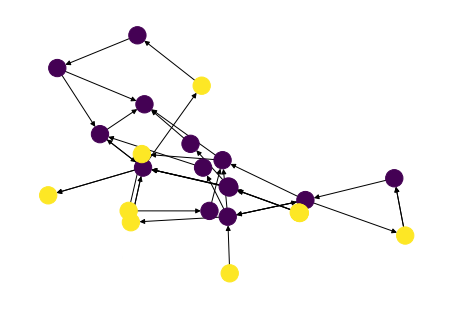

In [260]:
import matplotlib.pyplot as plt
%matplotlib inline
print(len(node_list), len(potential_node))
nx_S = graph_S.to_networkx()
pos = nx.kamada_kawai_layout(nx_S)
nx.draw(nx_S, pos, node_color = np.zeros(len(node_list)))
plt.show()
nx_G = graph_G.to_networkx()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, node_color = np.concatenate([np.zeros(len(node_list)), np.ones(len(potential_node[:10]))]))
plt.show()

In [261]:
#nx.is_connected(nx_S.to_undirected())
nx_G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24))

In [262]:
def gen_training_set(seed_graph, new_nodes_num, num = 512):
    sampler_list = create_graph_sampler()
    X = []
    y = []
    count = 0
    i = -1
    while count < num:
        i += 1
        node_list = gen_subgraph_nodes(sampler_list, i)
        potential_node = generate_neighbor(node_list, seed_graph)
        potential_node = potential_node - set(node_list)
        #print(len(node_list), len(potential_node))
        if len(node_list) == 15 and len(potential_node) >= new_nodes_num:
            potential_node = np.random.choice(np.array(list(potential_node)), new_nodes_num, replace = False)
            X.append(list(node_list))
            y.append(list(potential_node))
            count += 1
    return X,y

In [263]:
X,y = gen_training_set(sub_graph_G, 3, 100)

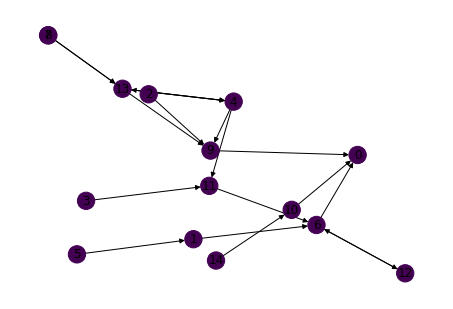

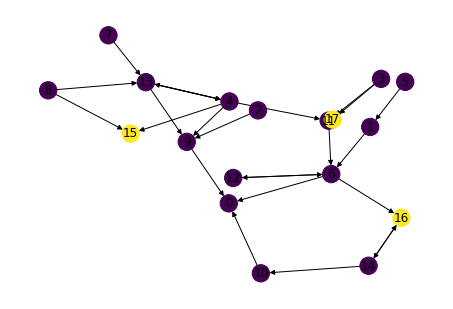

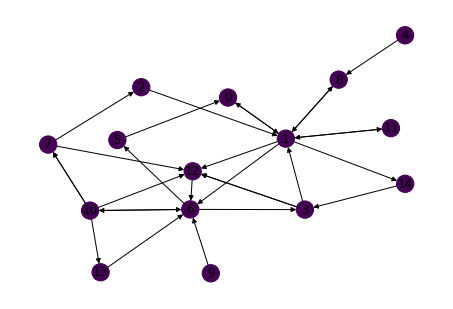

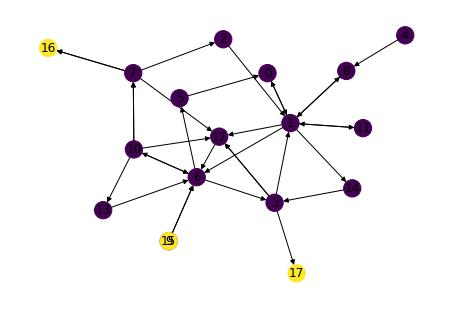

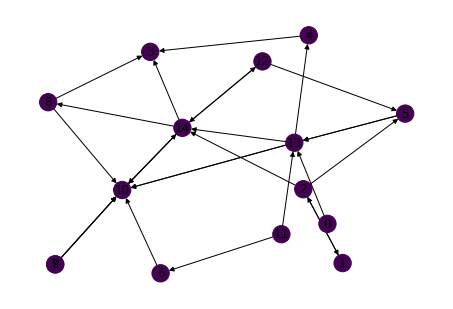

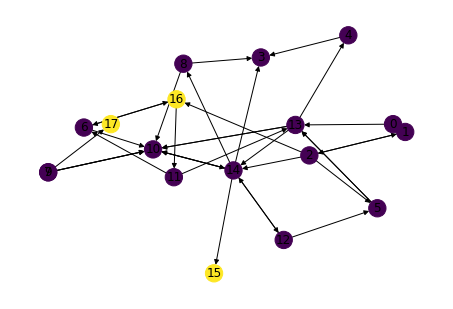

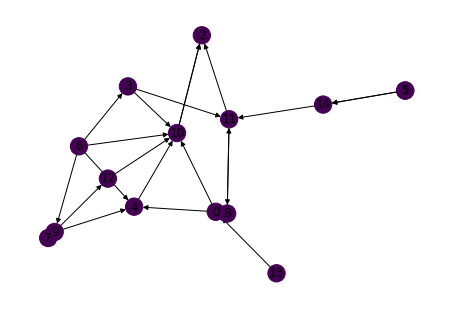

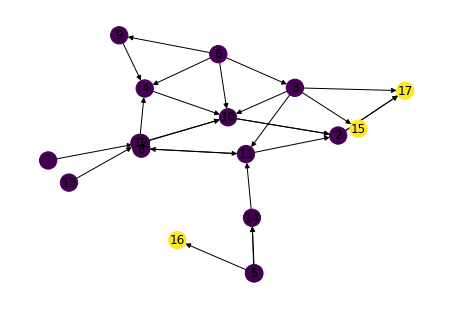

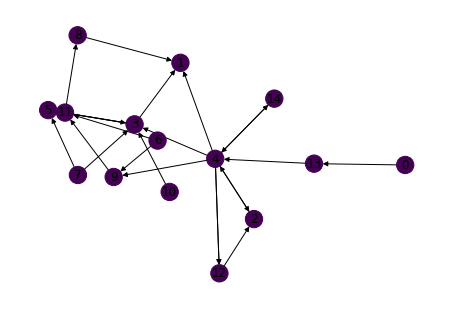

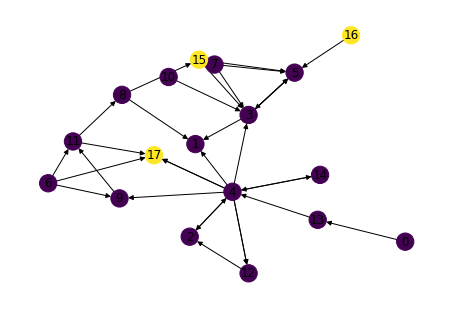

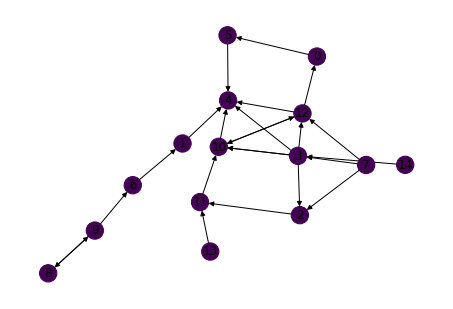

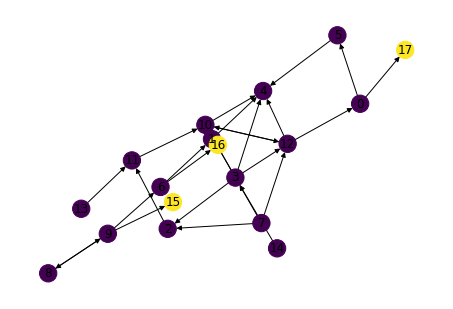

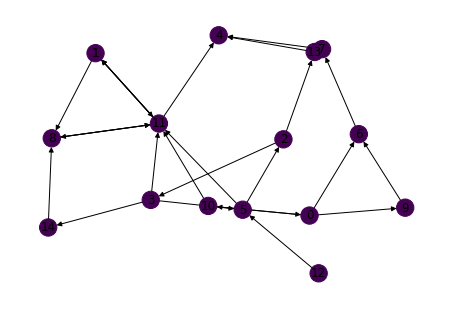

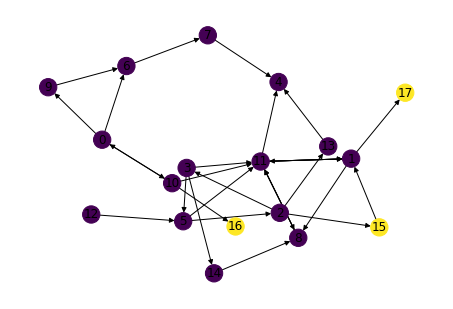

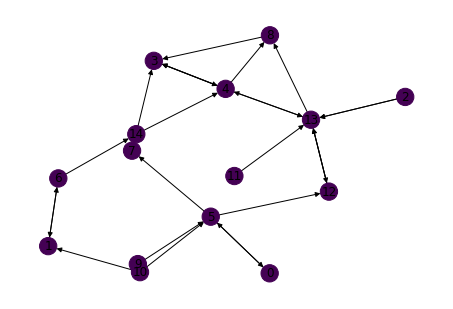

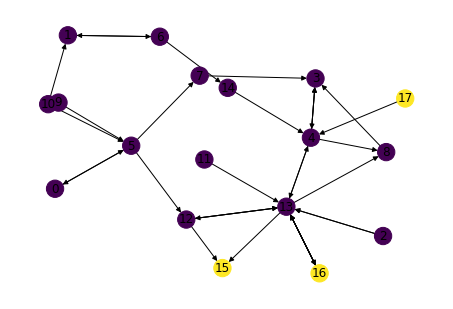

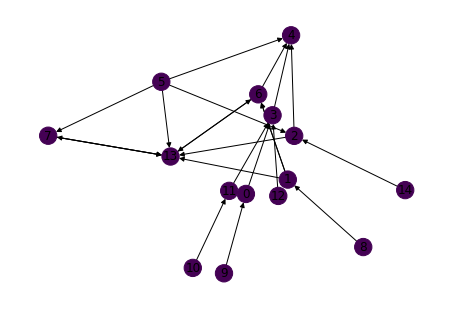

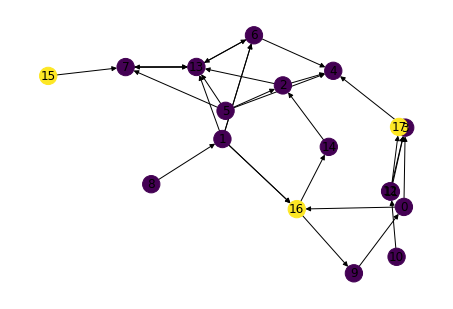

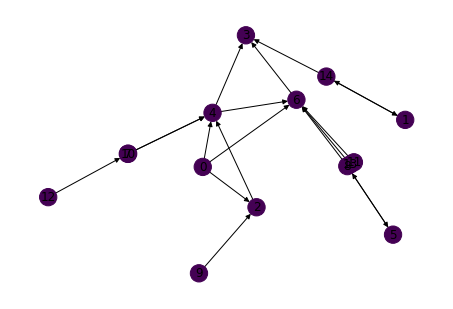

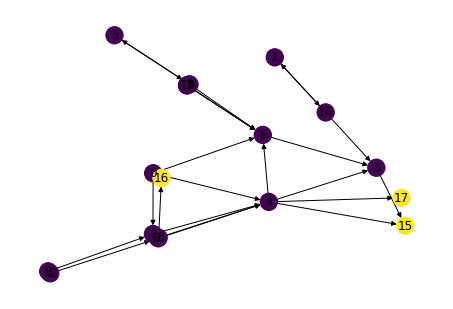

In [264]:
for i in range(10):
    node_list = X[i]
    potential_node = y[i]
    graph_S = sub_graph_G.subgraph(node_list)
    graph_S.copy_from_parent()

    graph_G = sub_graph_G.subgraph(node_list + potential_node)
    graph_G.copy_from_parent()
    
    nx_S = graph_S.to_networkx()
    pos = nx.kamada_kawai_layout(nx_S)
    nx.draw(nx_S, pos, with_labels = True, node_color = np.zeros(len(node_list)))
    plt.show()
    nx_G = graph_G.to_networkx()
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels = True, node_color = np.concatenate([np.zeros(len(node_list)), np.ones(len(potential_node))]))
    plt.show()

In [268]:
with open("DGL_graph.pkl", "wb") as f:
    pickle.dump(g, f)